In [56]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc as pm

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 8998
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

def sampler_kwargs():
    return dict(
        nuts_sampler="nutpie",
        chains=2,
        draws=500,
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

project_dir = Path.cwd().parent
train_df = pd.read_csv(project_dir / "data" / "model" / "training_data.csv",
    parse_dates=True,
    date_format="%Y %b",
    index_col=0,
    dtype={"value": float},
)

start_index = 630
M = 10
D = 10


In [57]:
Z_data = train_df.copy().values[start_index: start_index + M + D]
y_data = train_df.copy()[start_index: start_index + M + D].sum(axis=1)
y_data.index = pd.to_datetime(y_data.index)
mask = np.ones_like(Z_data, dtype=bool)

def mask_matrix(matrix):
        masked_matrix = matrix.copy()
        nrow, ncol = masked_matrix.shape

        for i in range(nrow):
            for j in range(ncol):
                if i + j > D - 1:
                     masked_matrix[i, j] = False
        return  masked_matrix

mask[-D:] = mask_matrix(np.array(mask[-D:]))


def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

t = np.arange(0, len(Z_data))
# Ensures not forward looking
Z_data[~mask] = 0

Z_data

array([[15, 26, 16, 44, 25, 25, 24, 29,  3,  1],
       [16, 29, 37, 37, 23, 14, 22,  2,  0,  8],
       [11, 60, 43, 37, 24, 36,  7,  1, 17,  3],
       [33, 60, 41, 37, 21,  4,  3, 36, 13, 14],
       [27, 54, 53, 38,  4,  6, 30, 17,  9,  2],
       [26, 44, 55, 21,  9, 36, 27, 11, 11,  7],
       [25, 60, 20,  7, 35, 30, 15, 30, 12,  1],
       [30, 40, 31, 66, 33, 27, 28, 22,  1,  3],
       [23, 31, 38, 42, 21, 26, 22,  6,  1, 15],
       [16, 48, 47, 37, 34, 34, 10,  2, 26, 10],
       [27, 72, 43, 40, 38,  9,  9, 37, 19,  6],
       [27, 52, 47, 43,  7, 10, 35, 25, 11,  0],
       [24, 72, 53, 12, 11, 24, 23, 32,  0,  0],
       [27, 54, 21,  9, 46, 26, 26,  0,  0,  0],
       [16, 29, 18, 50, 28, 25,  0,  0,  0,  0],
       [10, 37, 47, 41, 32,  0,  0,  0,  0,  0],
       [13, 55, 51, 41,  0,  0,  0,  0,  0,  0],
       [28, 79, 49,  0,  0,  0,  0,  0,  0,  0],
       [16, 63,  0,  0,  0,  0,  0,  0,  0,  0],
       [23,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

Time varying prop vector

In [42]:
def proportion_net(Z_data, n_hidden=10, output_dim=D):
    T, D = Z_data.shape
    # Prior
    W1_prop_net = pm.Normal("W1_prop_net", mu=0, sigma=1, shape=(D, n_hidden))
    b1_prop_net = pm.Normal("b1_prop_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_prop_net = pm.Normal("W2_prop_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_prop_net = pm.Normal("b2_prop_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_prop_net = pm.Normal("W3_prop_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_prop_net = pm.Normal("b3_prop_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h1 = pm.math.tanh(pm.math.dot(Z_data, W1_prop_net) + b1_prop_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_prop_net) + b2_prop_net)
    p_raw = pm.math.dot(h2, W3_prop_net) + b3_prop_net  # shape (T, D)
    
    return p_raw

def excess_net(Z_data, n_hidden=10, output_dim=M+D):
    T, D = Z_data.shape
    # Prior
    W1_excess_net = pm.Normal("W1_excess_net", mu=0, sigma=1, shape=(T*D, n_hidden))
    b1_excess_net = pm.Normal("b1_excess_net", mu=0, sigma=1, shape=(n_hidden,))

    W2_excess_net = pm.Normal("W2_excess_net", mu=0, sigma=1, shape=(n_hidden, n_hidden))
    b2_excess_net = pm.Normal("b2_excess_net", mu=0, sigma=1, shape=(n_hidden,))
    
    W3_excess_net = pm.Normal("W3_excess_net", mu=0, sigma=1, shape=(n_hidden, output_dim))
    b3_excess_net = pm.Normal("b3_excess_net", mu=0, sigma=1, shape=(output_dim,))
    
    # Forward pass
    h0 = pm.math.flatten(Z_data)
    h1 = pm.math.tanh(pm.math.dot(h0, W1_excess_net) + b1_excess_net)  # shape (T, n_hidden)
    h2 = pm.math.tanh(pm.math.dot(h1, W2_excess_net) + b2_excess_net)
    p_raw = pm.math.dot(h2, W3_excess_net) + b3_excess_net  # shape (T, D)
    
    return p_raw

with pm.Model() as model:
    t_shared = pm.Data("t", t)
    Z_shared = pm.Data("Z_data", Z_data)

    # Linear trend parameters
    b0 = pm.Normal("b0", mu=0, sigma=0.5)   # intercept
    b1 = pm.Normal("b1", mu=0, sigma=0.5)
    # mean_func = pm.gp.mean.Linear(coeffs=b1, intercept=b0)


    # ell = pm.Gamma("ell", alpha=10, beta=1)   # length scale
    # eta = pm.HalfNormal("eta", sigma=2)      # amplitude
    # cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)

    # gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    # f = gp.prior("f", X=t_shared[:, None])

    # fourier_shared = create_fourier_features(t_shared, n=10, p=3.5)
    # beta_fourier = pm.Normal("beta_fourier", 0, 0.1, shape=fourier_shared.shape[1])
    # seasonality = pm.Deterministic(
    #     "seasonality", pm.math.dot(fourier_shared, beta_fourier)
    # )
    
    log_lam = b0 + b1*t_shared + excess_net(Z_shared, n_hidden=10, output_dim=M+D)
    lam = pm.Deterministic("lam", pm.math.exp(log_lam))

    
    # p_raw = proportion_net(Z_shared, n_hidden=10, output_dim=D)
    # p = pm.Deterministic("p", pm.math.softmax(p_raw, axis=1))
    p = pm.Dirichlet("p", a=np.arange(D,0, -1))

    # Create matrix of lam[t,:] * p[t,d]
    mu = lam[:, None] * p

    alpha = pm.HalfNormal("alpha", sigma=2)  # overdispersion param
    # y_hat = pm.NegativeBinomial("y_hat", mu=lam, alpha=alpha)

    
    z = pm.NegativeBinomial("z", mu[mask], alpha, observed=Z_data[mask])

    idata = pm.sample(**sampler_kwargs())

with model:
    #in-sample 
    ppc = pm.sample_posterior_predictive(idata, extend_inferencedata=True, var_names=['z', 'lam', 'p'])
    


Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,31,0.00,1023
,1500,27,0.00,1023


Sampling: [p, z]


Output()

/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_61535/183279936.py:5: FutureWarning: extract_dataset has been deprecated, please use extract
  lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
/var/folders/5f/9g0vtmkj22j_xbhxyrknnv140000gn/T/ipykernel_61535/183279936.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


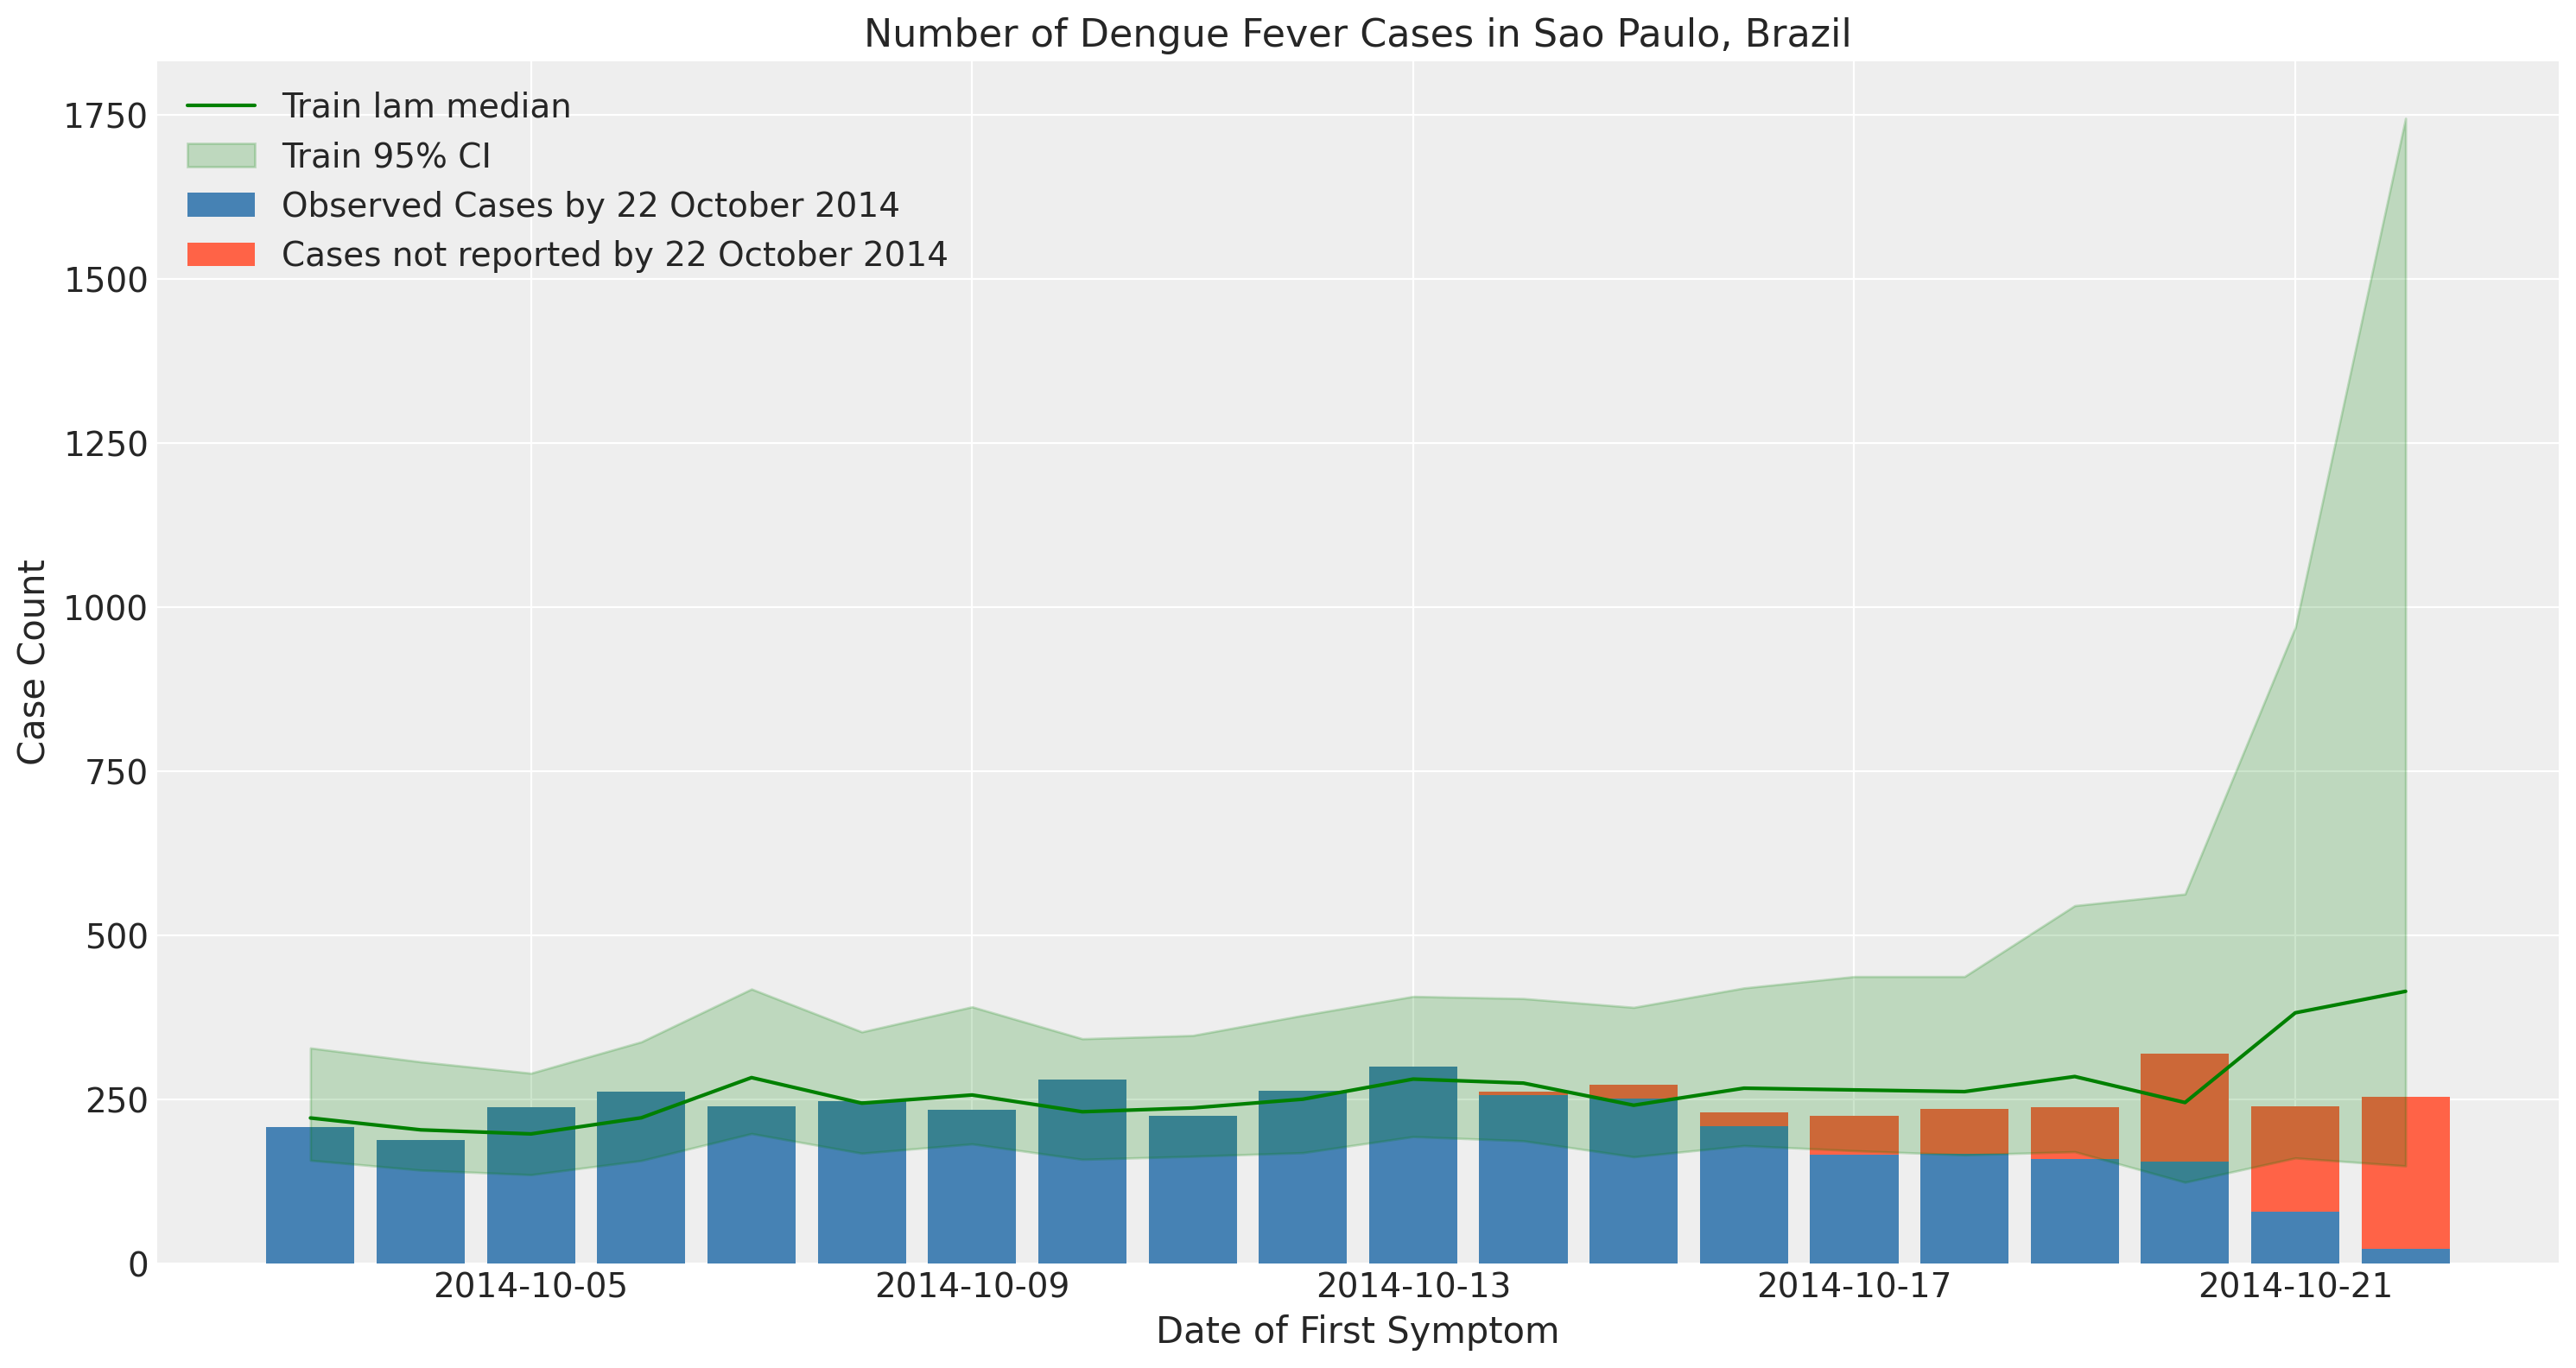

In [58]:
y_obs = Z_data.sum(1)
y_gap = y_data - y_obs

# in sample
lam_post_samples = az.extract_dataset(ppc, group="posterior", num_samples=1000)["lam"]
med_train = np.percentile(lam_post_samples, 50, axis=1)
lower_train = np.percentile(lam_post_samples, 2.5, axis=1)
upper_train = np.percentile(lam_post_samples, 97.5, axis=1)




# Plot stacked bars
plt.figure(figsize=(15, 8))

plt.bar(y_data.index, y_obs, color="steelblue", label=f"Observed Cases by {y_data.index[-1].strftime("%d %B %Y")}")
plt.bar(y_data.index, y_gap, bottom=y_obs, color="tomato", label=f"Cases not reported by {y_data.index[-1].strftime("%d %B %Y")}")

# Plot CI for training data
plt.plot(y_data.index,  med_train, color='green', label="Train lam median")
plt.fill_between(y_data.index, lower_train, upper_train, color='green', alpha=0.2, label='Train 95% CI')


plt.title("Number of Dengue Fever Cases in Sao Paulo, Brazil")
plt.xlabel("Date of First Symptom")
plt.ylabel("Case Count")
plt.legend()
plt.tight_layout()
plt.show()